# TensorFlow roBERTa Starter - LB 0.705
This notebook is a TensorFlow template for solving Kaggle's Tweet Sentiment Extraction competition as a question and answer roBERTa formulation. In this notebook, we show how to tokenize the data, create question answer targets, and how to build a custom question answer head for roBERTa in TensorFlow. Note that HuggingFace transformers don't have a `TFRobertaForQuestionAnswering` so we must make our own from `TFRobertaModel`. This notebook can achieve LB 0.715 with some modifications. Have fun experimenting!

You can also run this code offline and it will save the best model weights during each of the 5 folds of training. Upload those weights to a private Kaggle dataset and attach to this notebook. Then you can run this notebook with the line `model.fit()` commented out, and this notebook will instead load your offline models. It will use your offline models to predict oof and predict test. Hence this notebook can easily be converted to an inference notebook. An inference notebook is advantageous because it will only take 10 minutes to commit and submit instead of 2 hours. Better to train 2 hours offline separately.

# Load Libraries, Data, Tokenizer
We will use HuggingFace transformers [here][1]

[1]: https://huggingface.co/transformers/

In [1]:
import pandas as pd, numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
from transformers import *
import tokenizers
print('TF version',tf.__version__)

TF version 2.1.0


In [2]:
MAX_LEN = 96
PATH = '../input/tf-roberta/'
tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab_file=PATH+'vocab-roberta-base.json', 
    merges_file=PATH+'merges-roberta-base.txt', 
    lowercase=True,
    add_prefix_space=True
)
sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}
train = pd.read_csv('../input/tweet-sentiment-extraction/train.csv').fillna('')
train.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

# Training Data
We will now convert the training data into arrays that roBERTa understands. Here are example inputs and targets: 
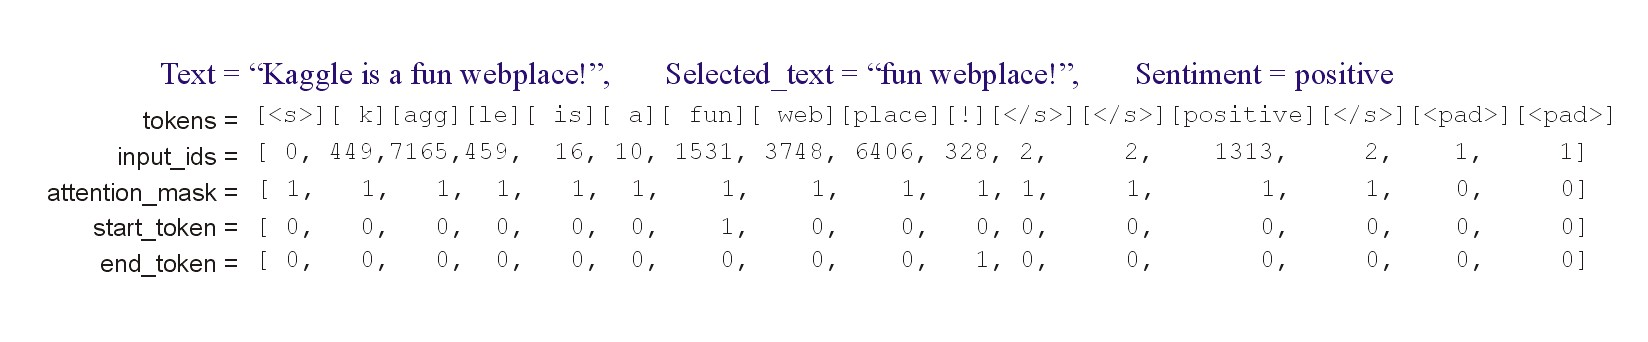
The tokenization logic below is inspired by Abhishek's PyTorch notebook [here][1].

[1]: https://www.kaggle.com/abhishek/roberta-inference-5-folds

In [3]:
ct = train.shape[0]
input_ids = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids = np.zeros((ct,MAX_LEN),dtype='int32')
start_tokens = np.zeros((ct,MAX_LEN),dtype='int32')
end_tokens = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(train.shape[0]):
    
    # FIND OVERLAP
    text1 = " "+" ".join(train.loc[k,'text'].split())
    text2 = " ".join(train.loc[k,'selected_text'].split())
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ': chars[idx-1] = 1 
    enc = tokenizer.encode(text1) 
        
    # ID_OFFSETS
    offsets = []; idx=0
    for t in enc.ids:
        w = tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)
    
    # START END TOKENS
    toks = []
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0: toks.append(i) 
        
    s_tok = sentiment_id[train.loc[k,'sentiment']]
    input_ids[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask[k,:len(enc.ids)+5] = 1
    if len(toks)>0:
        start_tokens[k,toks[0]+1] = 1
        end_tokens[k,toks[-1]+1] = 1

# Test Data
We must tokenize the test data exactly the same as we tokenize the training data

In [4]:
test = pd.read_csv('../input/tweet-sentiment-extraction/test.csv').fillna('')

ct = test.shape[0]
input_ids_t = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask_t = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids_t = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(test.shape[0]):
        
    # INPUT_IDS
    text1 = " "+" ".join(test.loc[k,'text'].split())
    enc = tokenizer.encode(text1)                
    s_tok = sentiment_id[test.loc[k,'sentiment']]
    input_ids_t[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask_t[k,:len(enc.ids)+5] = 1

# Build roBERTa Model
We use a pretrained roBERTa base model and add a custom question answer head. First tokens are input into `bert_model` and we use BERT's first output, i.e. `x[0]` below. These are embeddings of all input tokens and have shape `(batch_size, MAX_LEN, 768)`. Next we apply `tf.keras.layers.Conv1D(filters=1, kernel_size=1)` and transform the embeddings into shape `(batch_size, MAX_LEN, 1)`. We then flatten this and apply `softmax`, so our final output from `x1` has shape `(batch_size, MAX_LEN)`. These are one hot encodings of the start tokens indicies (for `selected_text`). And `x2` are the end tokens indicies.

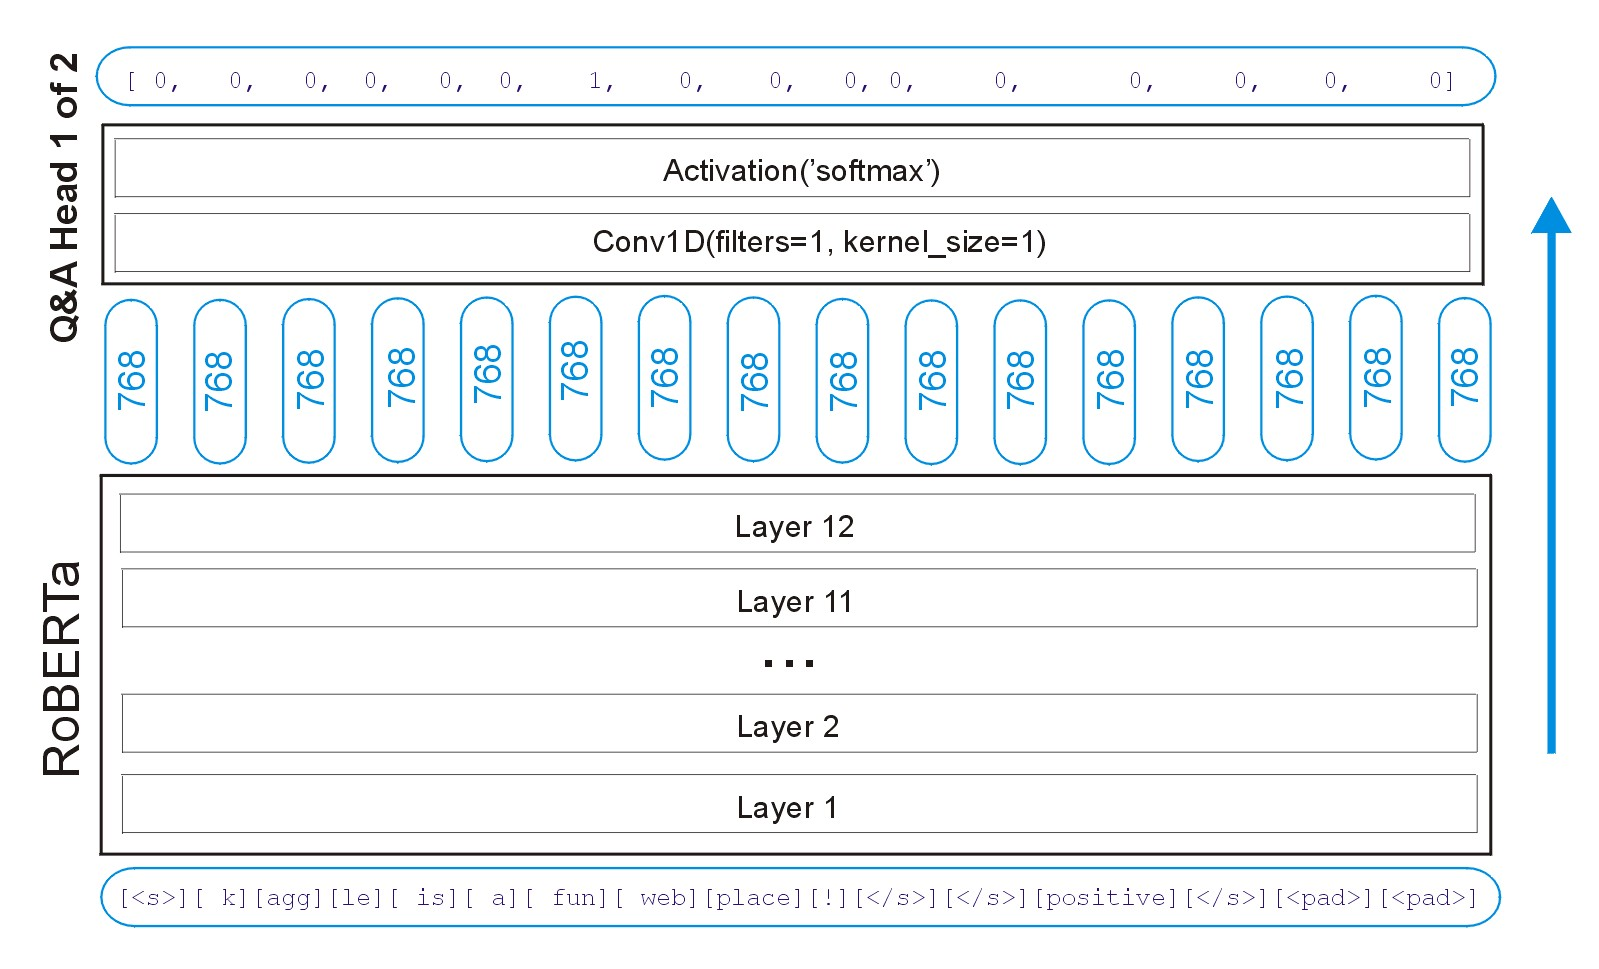

In [5]:
def build_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)

    config = RobertaConfig.from_pretrained(PATH+'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x = bert_model(ids,attention_mask=att,token_type_ids=tok)
    
    x1 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x1 = tf.keras.layers.Conv1D(1,1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)
    
    x2 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x2 = tf.keras.layers.Conv1D(1,1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)

    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)

    return model

# Metric

In [6]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

# Train roBERTa Model
We train with 5 Stratified KFolds (based on sentiment stratification). Each fold, the best model weights are saved and then reloaded before oof prediction and test prediction. Therefore you can run this code offline and upload your 5 fold models to a private Kaggle dataset. Then run this notebook and comment out the line `model.fit()`. Instead your notebook will load your model weights from offline training in the line `model.load_weights()`. Update this to have the correct path. Also make sure you change the KFold seed below to match your offline training. Then this notebook will proceed to use your offline models to predict oof and predict test.

In [7]:
jac = []; VER='v0'; DISPLAY=1 # USE display=1 FOR INTERACTIVE
oof_start = np.zeros((input_ids.shape[0],MAX_LEN))
oof_end = np.zeros((input_ids.shape[0],MAX_LEN))
preds_start = np.zeros((input_ids_t.shape[0],MAX_LEN))
preds_end = np.zeros((input_ids_t.shape[0],MAX_LEN))

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=777)
for fold,(idxT,idxV) in enumerate(skf.split(input_ids,train.sentiment.values)):

    print('#'*25)
    print('### FOLD %i'%(fold+1))
    print('#'*25)
    
    K.clear_session()
    model = build_model()
        
    sv = tf.keras.callbacks.ModelCheckpoint(
        '%s-roberta-%i.h5'%(VER,fold), monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='auto', save_freq='epoch')
        
    model.fit([input_ids[idxT,], attention_mask[idxT,], token_type_ids[idxT,]], [start_tokens[idxT,], end_tokens[idxT,]], 
        epochs=3, batch_size=32, verbose=DISPLAY, callbacks=[sv],
        validation_data=([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]], 
        [start_tokens[idxV,], end_tokens[idxV,]]))
    
    print('Loading model...')
    model.load_weights('%s-roberta-%i.h5'%(VER,fold))
    
    print('Predicting OOF...')
    oof_start[idxV,],oof_end[idxV,] = model.predict([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]],verbose=DISPLAY)
    
    print('Predicting Test...')
    preds = model.predict([input_ids_t,attention_mask_t,token_type_ids_t],verbose=DISPLAY)
    preds_start += preds[0]/skf.n_splits
    preds_end += preds[1]/skf.n_splits
    
    # DISPLAY FOLD JACCARD
    all = []
    for k in idxV:
        a = np.argmax(oof_start[k,])
        b = np.argmax(oof_end[k,])
        if a>b: 
            st = train.loc[k,'text'] # IMPROVE CV/LB with better choice here
        else:
            text1 = " "+" ".join(train.loc[k,'text'].split())
            enc = tokenizer.encode(text1)
            st = tokenizer.decode(enc.ids[a-1:b])
        all.append(jaccard(st,train.loc[k,'selected_text']))
    jac.append(np.mean(all))
    print('>>>> FOLD %i Jaccard ='%(fold+1),np.mean(all))
    print()

#########################
### FOLD 1
#########################
Train on 21984 samples, validate on 5497 samples
Epoch 1/3
21952/21984 [============================>.] - ETA: 0s - loss: 2.1719 - activation_loss: 1.0781 - activation_1_loss: 1.0938
Epoch 00001: val_loss improved from inf to 1.66941, saving model to v0-roberta-0.h5
21984/21984 [==============================] - 292s 13ms/sample - loss: 2.1719 - activation_loss: 1.0784 - activation_1_loss: 1.0936 - val_loss: 1.6694 - val_activation_loss: 0.8699 - val_activation_1_loss: 0.7994
Epoch 2/3
21952/21984 [============================>.] - ETA: 0s - loss: 1.5980 - activation_loss: 0.8268 - activation_1_loss: 0.7712
Epoch 00002: val_loss improved from 1.66941 to 1.66494, saving model to v0-roberta-0.h5
21984/21984 [==============================] - 275s 12ms/sample - loss: 1.5985 - activation_loss: 0.8270 - activation_1_loss: 0.7715 - val_loss: 1.6649 - val_activation_loss: 0.8726 - val_activation_1_loss: 0.7921
Epoch 3/3
21952/2198

In [8]:
print('>>>> OVERALL 5Fold CV Jaccard =',np.mean(jac))

>>>> OVERALL 5Fold CV Jaccard = 0.7029308519012358


# Kaggle Submission

In [9]:
all = []
for k in range(input_ids_t.shape[0]):
    a = np.argmax(preds_start[k,])
    b = np.argmax(preds_end[k,])
    if a>b: 
        st = test.loc[k,'text']
    else:
        text1 = " "+" ".join(test.loc[k,'text'].split())
        enc = tokenizer.encode(text1)
        st = tokenizer.decode(enc.ids[a-1:b])
    all.append(st)

In [10]:
test['selected_text'] = all
test[['textID','selected_text']].to_csv('submission.csv',index=False)
pd.set_option('max_colwidth', 60)
test.sample(25)

textID                                                         text  \
2038  778c5660f8  Justin Timberlake and Andy Samberg do it again.. Mother ...   
1908  6788d6c565  Aww the little girl on Britain`s Got Talent!  I actually...   
2063  5423cf0811  anyone have tickets to the mtv movie awards? some guy sc...   
2857  16fd300910  Ive been passed out drunk for the passed couple of hours...   
255   1e0416ec46  just rocked home from maccas, and now signing a petition...   
3465  d461b50edb  really bored today. just ate a bowl ful of rasberries an...   
1339  51bdb4d865              Feeling very tierd! too much college work!!!!!!   
1506  1a38bc0602                Hates having broken wrist and has PE next ugh   
584   4f7cba2eff   ach, probably not... they are labeled as MI-5, which I ...   
3164  3ff2b333c3   I can only imagine, but I know I love hearing about you...   
1898  b84d47c65f  http://twitpic.com/66ymw I`m gonna miss these guys so mu...   
2382  380c3d243a  Almost ready for new Beta.... until we found a showstopp...   
703   e027169ec6  Grinding Skyguard rep. This is less awful than I anticip...   
3310  01fdd344f2  _Advisor haha I`m just going to turn off these things......   
1668  4e43ad756c                     Aw it says the pic doesn`t exist anymore   
644   c180265483  Sites that republish my blog`s feed often end up higher ...   
633   dfd9f1800b                                       man, I am really sorry   
1107  d554ee2fe0  just got up, couldn`t sleep anymore i guess and im not r...   
2682  f5e5205d2e   You know I am so ashamed. I did not watch a single epis...   
1795  7017d6c8cf  I just downloaded a ton of stunning, BEAUTIFUL wallpaper...   
573   13c47e9bc8  got an awesome hair cut todayyyy  it looks so hottt haha...   
375   0437867c21                                                    So tired.   
2250  f7f3dc7102                 no, New orleans.. been here since katrina ..   
74    972dc5787d                           _LaMont yr very young looking dude   
2155  291b817092                         I`m feel deflated. Ugh. No more dog.   

     sentiment                                                selected_text  
2038  positive                                                        great  
1908  positive                                                         love  
2063  negative                                                   scammed me  
2857   neutral   ive been passed out drunk for the passed couple of hour...  
255    neutral   just rocked home from maccas, and now signing a petitio...  
3465  negative                                                        bored  
1339  negative                                          feeling very tierd!  
1506  negative                                                        hates  
584    neutral   ach, probably not... they are labeled as mi-5, which i ...  
3164  positive                                                         love  
1898  positive      thanks for making the 5 years at senior school amazing!  
2382  negative                                             showstopping bug  
703   negative                  awful than i anticipated. yet, still awful.  
3310  negative                                             stupid spammers!  
1668  negative                     aw it says the pic doesn`t exist anymore  
644   negative    often end up higher than my blog on google search results  
633   negative                                                        sorry  
1107   neutral   just got up, couldn`t sleep anymore i guess and im not ...  
2682  negative                                                     ashamed.  
1795  positive                                                    beautiful  
573   positive                                                      awesome  
375   negative                                                    so tired.  
2250   neutral                 no, new orleans.. been here since katrina ..  
74    positive                 